<h1>02 – EDA - City level<span class="tocSkip"></span></h1>

# Setup & Configs

In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Just change the city and run all cells
city='Indore'
years = list(range(1981, 2024 + 1))

In [5]:

def ls(path, indent='', level=0):
    try:
        items = sorted(os.listdir(path))
    except PermissionError:
        items = []

    # separate files and folders
    files = [i for i in items if os.path.isfile(os.path.join(path, i))]
    dirs = [i for i in items if os.path.isdir(os.path.join(path, i))]
    items = files + dirs  # files first, then folders

    if level == 0:
        max_items = None
    elif level == 1:
        max_items = 2
    else:
        max_items = 2

    if max_items is None:
        items_to_show = items
        more = False
    else:
        items_to_show = items[:max_items]
        more = len(items) > max_items

    for item in items_to_show:
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print(indent + f"\033[1;34m{item}\033[0m/")
            ls(full_path, indent + '  ', level + 1)
        else:
            print(indent + item)

    if more:
        print(indent + '...')

data_dir = '../data'
print(f"\033[1;31m{data_dir}\033[0m")
ls(data_dir)

../data
city_list.csv
smart_cities.csv
gee_exports/
  Bhopal/
    Bhopal_dem.tif
    Bhopal_distance.tif
    ...
  Gwalior/
    Gwalior_dem.tif
    Gwalior_distance.tif
    ...
  ...
shapefiles/
  india_boundary.zip
  india_boundary/
    india_boundary.cpg
    india_boundary.dbf
    ...
  ...


# Data

In [7]:
# Load boundary shapefile
from shapely.geometry import shape
import ee
ee.Authenticate()
ee.Initialize()

roi = ee.FeatureCollection(f"projects/ee-539srijansiddharth/assets/Smart-Cities-India/{city}")
features = roi.getInfo()['features']

roi_gdf = gpd.GeoDataFrame(
    [f['properties'] for f in features],
    geometry=[shape(f['geometry']) for f in features],
    crs='EPSG:4326'
)

bounds = roi_gdf.geometry.bounds.values[0]
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]

In [10]:

def load_temporal_feature(folder, var_name, years, city, nodata_val=-9999):
    arrays = []
    
    for year in years:
        pattern = os.path.join(folder, f"{city}_{var_name}_{year}.tif")
        
        da = rioxarray.open_rasterio(pattern, masked=True).squeeze("band", drop=True)
        da = da.where(da != nodata_val)
        da = da.assign_coords(time=year).expand_dims("time")
        arrays.append(da)
    
    if not arrays:
        raise ValueError(f"No files found for {var_name} in {folder}")
    
    return xr.concat(arrays, dim="time").rename(var_name)

def load_static_feature(path, var_name, nodata_val=-9999):
    da = rioxarray.open_rasterio(path, masked=True).squeeze("band", drop=True)
    da = da.where(da != nodata_val)
    return da.rename(var_name)


In [11]:
# Load Temporal and Static data
risk = load_temporal_feature(f"../data/gee_exports/{city}/{city}_risk", "risk", range(1981, 2024+1), city)
rainfall = load_temporal_feature(f"../data/gee_exports/{city}/{city}_rainfall", "rainfall", range(1981, 2024+1), city)
runoff = load_temporal_feature(f"../data/gee_exports/{city}/{city}_runoff", "runoff", range(1981, 2024+1), city)
population = load_temporal_feature(f"../data/gee_exports/{city}/{city}_population", "population", range(1980, 2020 + 1, 5), city)

dem = load_static_feature(f"../data/gee_exports/{city}/{city}_dem.tif", "dem")
ndvi = load_static_feature(f"../data/gee_exports/{city}/{city}_ndvi.tif", "ndvi")
ndwi = load_static_feature(f"../data/gee_exports/{city}/{city}_ndwi.tif", "ndwi")
tpi = load_static_feature(f"../data/gee_exports/{city}/{city}_tpi.tif", "tpi")
dist_water = load_static_feature(f"../data/gee_exports/{city}/{city}_distance.tif", "distance")

In [12]:
# Merge dataset
ds = xr.merge(
    [risk, rainfall, runoff, population, dem, ndvi, ndwi, tpi, dist_water],
    join='outer',
    compat='no_conflicts'
)

## Inspection

In [ ]:
ds

<xarray.Dataset> Size: 892MB
Dimensions:      (x: 738, y: 819, time: 45)
Coordinates:
  * x            (x) float64 6kB 75.77 75.77 75.77 75.77 ... 75.96 75.96 75.96
  * y            (y) float64 7kB 22.84 22.84 22.84 22.84 ... 22.62 22.62 22.62
  * time         (time) int32 180B 1980 1981 1982 1983 ... 2021 2022 2023 2024
    spatial_ref  int32 4B 0
Data variables:
    risk         (time, y, x) float64 218MB nan nan nan nan ... nan nan nan nan
    rainfall     (time, y, x) float64 218MB nan nan nan nan ... nan nan nan nan
    runoff       (time, y, x) float64 218MB nan nan nan nan ... nan nan nan nan
    population   (time, y, x) float64 218MB nan nan nan nan ... nan nan nan nan
    dem          (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    ndvi         (y, x) float64 5MB nan nan nan nan nan ... nan nan nan nan nan
    ndwi         (y, x) float64 5MB nan nan nan nan nan ... nan nan nan nan nan
    tpi          (y, x) float64 5MB nan nan nan nan nan ... nan nan nan nan nan
    distance     (y, x) float64 5MB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
# Check consistency of temporal features across all pixels
for var in ['risk', 'rainfall', 'runoff', 'population']:
    data = ds[var].values
    data_valid = data[np.any(~np.isnan(data), axis=(1, 2))]
    
    inconsistent_pixels = ~(np.all(np.isnan(data_valid), axis=0) | np.all(~np.isnan(data_valid), axis=0))
    
    assert np.sum(inconsistent_pixels) == 0, f"Inconsistent pixels in {var}"

In [ ]:

total_pixels = ds.sizes['y'] * ds.sizes['x']
print(f"Total Pixels: {total_pixels}\n")
print("# Feature          Non-Null Pixels      Non-Null Images    Dtype      Type")
print("---  ------        ------------------  -----------------  ---------  -------")

for i, var in enumerate(ds.data_vars):
    data = ds[var].values
    dtype = str(ds[var].dtype)
    
    if 'time' in ds[var].sizes:
        var_type = 'Temporal'
        valid_times = np.any(~np.isnan(data), axis=(1, 2))
        first_valid_idx = np.argmax(valid_times)
        non_null_pixel_count = np.sum(~np.isnan(data[first_valid_idx]))
        non_null_image_count = np.sum(valid_times)
    else:
        var_type = 'Static'
        non_null_pixel_count = np.sum(~np.isnan(data))
        non_null_image_count = '-'
    
    print(f"{i:<3}  {var:<12}  {non_null_pixel_count:<19}  {non_null_image_count:<20}  {dtype:<9}  {var_type}")

Total Pixels: 604422

# Feature          Non-Null Pixels      Non-Null Images    Dtype      Type
---  ------        ------------------  -----------------  ---------  -------
0    risk          358899               44                    float64    Temporal
1    rainfall      359509               44                    float64    Temporal
2    runoff        359509               44                    float64    Temporal
3    population    359509               9                     float64    Temporal
4    dem           359509               -                     float32    Static
5    ndvi          359509               -                     float64    Static
6    ndwi          359509               -                     float64    Static
7    tpi           359509               -                     float64    Static
8    distance      358899               -                     float64    Static


In [ ]:
# Keep valid pixels only across all features and time steps
mask = np.ones((ds.sizes['y'], ds.sizes['x']), dtype=bool)

for var in ds.data_vars:
    data = ds[var].values
    
    if 'time' in ds[var].dims:
        data = data[np.any(~np.isnan(data), axis=(1, 2))]
        mask &= np.all(~np.isnan(data), axis=0)
    else:
        mask &= ~np.isnan(data)

ds = ds.where(xr.DataArray(mask, dims=('y', 'x')))

In [ ]:

def compute_downsample_factor(ds, target_pixels=200):
    width = ds.sizes['x']
    height = ds.sizes['y']
    factor_x = width / target_pixels
    factor_y = height / target_pixels
    factor = max(factor_x, factor_y)
    return 1 if factor < 1 else 1 / factor

In [ ]:
# Downsample for EDA
from rasterio.enums import Resampling

downsample_factor = compute_downsample_factor(ds, target_pixels=200)

ds = ds.rio.reproject(
    ds.rio.crs,
    shape=(int(ds.sizes['y'] * downsample_factor), int(ds.sizes['x'] * downsample_factor)),
    resampling=Resampling.average
)

In [ ]:
target = 'risk'
static_att = ['dem', 'ndvi', 'ndwi', 'tpi', 'distance']
temporal_att = ['rainfall', 'runoff', 'population']

# Target analysis

In [ ]:
# Configs
data_matrix = ds['risk'].transpose('y', 'x', 'time')[:, :, 1:].values.reshape(-1, 44)
raster_shape = ds['risk'].shape[1:]
risk_thresh = 50

In [47]:

pd.DataFrame(data_matrix).describe([.25, .50, .75, 0.99]).T.describe().rename_axis('Risk', axis=1).round(2)

Risk,count,mean,std,min,25%,50%,75%,99%,max
count,44.0,44.00,44.00,44.00,44.00,44.00,44.00,44.00,44.00
mean,20817.0,8.64,4.15,3.80,6.05,6.77,9.27,21.44,27.04
std,0.0,1.42,0.97,0.52,0.75,0.89,2.04,3.55,4.68
min,20817.0,6.38,2.74,3.00,4.86,5.35,6.37,16.10,20.88
25%,20817.0,7.70,3.51,3.46,5.52,6.14,7.92,18.92,22.87
50%,20817.0,8.33,3.80,3.83,6.02,6.67,8.61,20.44,26.44
75%,20817.0,9.19,4.65,4.13,6.47,7.26,10.16,22.87,29.42
max,20817.0,12.31,6.65,5.04,7.83,9.02,14.67,31.17,39.30


In [54]:

from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_scale", ['blue', 'cyan', 'green', 'yellow', 'red'])

## Spatial analysis

### Spatial summary statistics

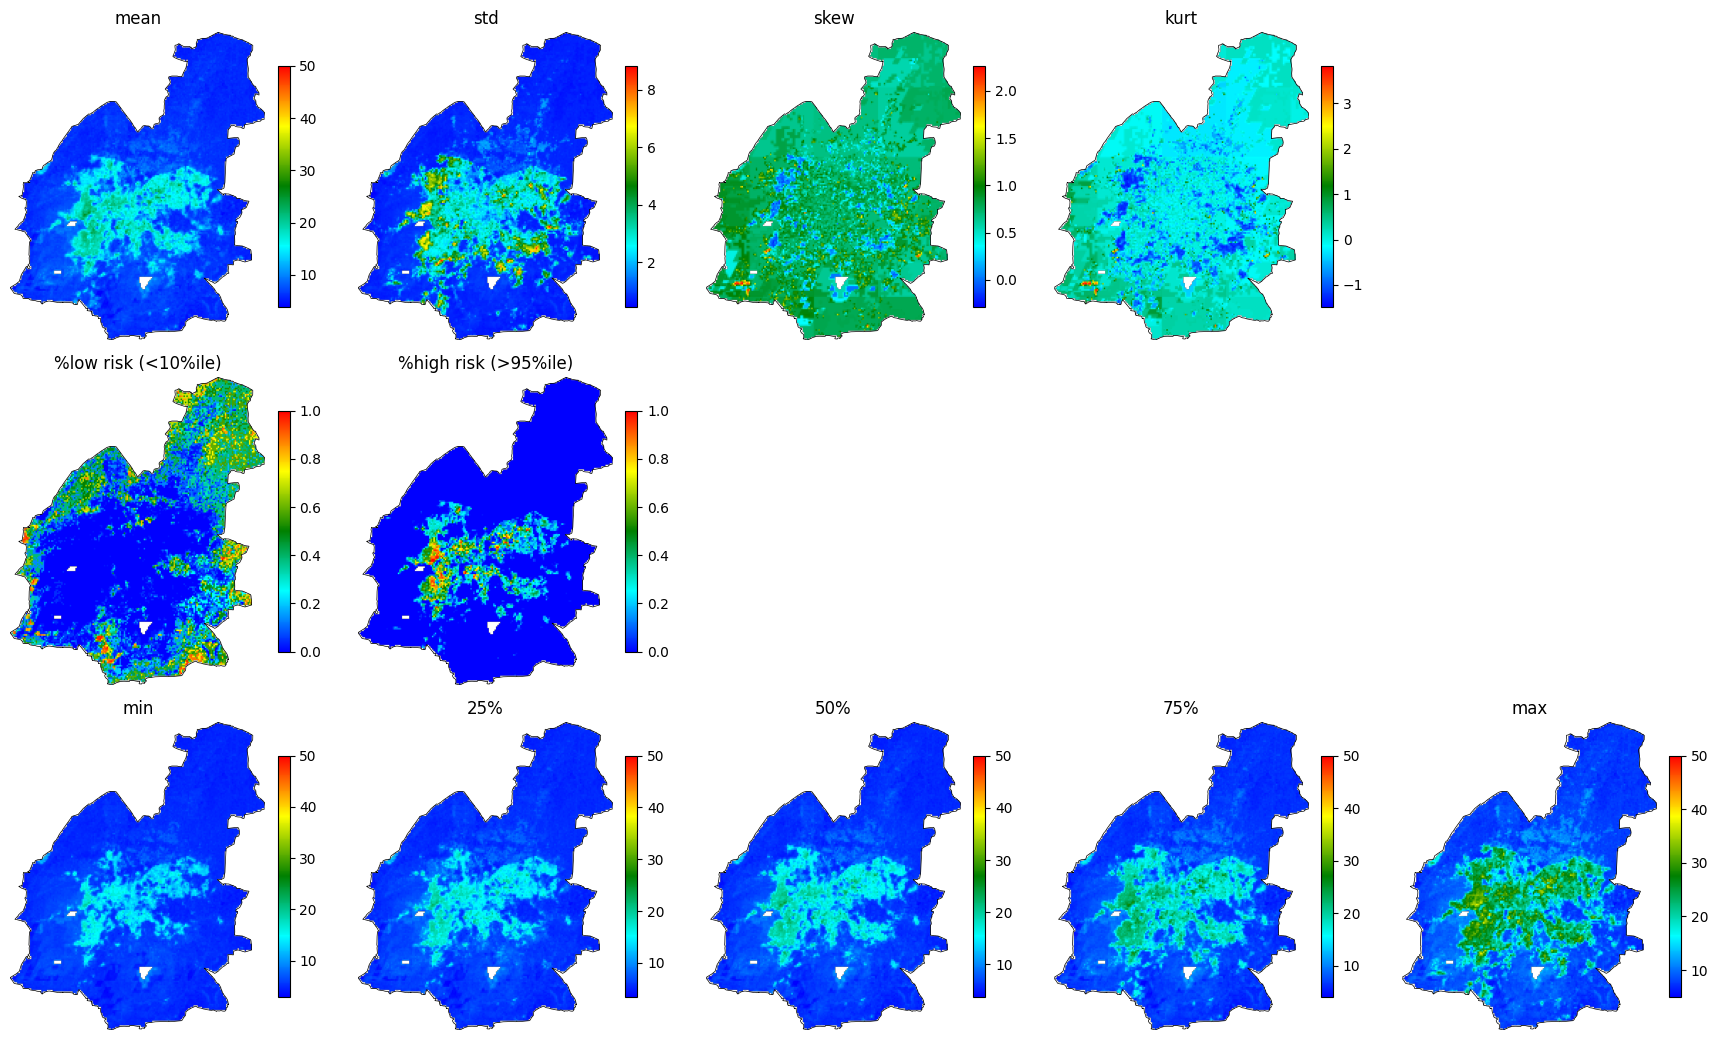

In [56]:

from scipy.stats import skew, kurtosis

# Spatial stats
mean_map = data_matrix.mean(axis=1).reshape(raster_shape)
std_map = data_matrix.std(axis=1).reshape(raster_shape)

valid_counts = np.sum(~np.isnan(data_matrix), axis=1)
skew_vals = np.full(data_matrix.shape[0], np.nan)
kurt_vals = np.full(data_matrix.shape[0], np.nan)

skew_vals[valid_counts >= 3] = skew(data_matrix[valid_counts >= 3], axis=1, nan_policy='omit')
kurt_vals[valid_counts >= 4] = kurtosis(data_matrix[valid_counts >= 4], axis=1, nan_policy='omit')

skew_map = skew_vals.reshape(raster_shape)
kurt_map = kurt_vals.reshape(raster_shape)


mask = np.isnan(data_matrix).all(axis=1) | (data_matrix == 0).all(axis=1)

threshold = np.percentile(data_matrix[~np.isnan(data_matrix).all(axis=1) & ~(data_matrix == 0).all(axis=1)], 95, axis=0).mean()
perc_high_risk_map = (data_matrix > threshold).mean(axis=1)
perc_high_risk_map[mask] = np.nan
perc_high_risk_map = perc_high_risk_map.reshape(raster_shape)

threshold = np.percentile(data_matrix[~np.isnan(data_matrix).all(axis=1) & ~(data_matrix == 0).all(axis=1)], 10, axis=0).mean()
perc_low_risk_map = (data_matrix < threshold).mean(axis=1)
perc_low_risk_map[mask] = np.nan
perc_low_risk_map = perc_low_risk_map.reshape(raster_shape)


min_map = np.min(data_matrix, axis=1).reshape(raster_shape)
p25_map = np.percentile(data_matrix, 25, axis=1).reshape(raster_shape)
p50_map = np.percentile(data_matrix, 50, axis=1).reshape(raster_shape)
p75_map = np.percentile(data_matrix, 75, axis=1).reshape(raster_shape)
max_map = np.max(data_matrix, axis=1).reshape(raster_shape)

titles = ['mean', 'std', 'skew', 'kurt', '%low risk (<10%ile)', '%high risk (>95%ile)', 'min', '25%', '50%', '75%', 'max']
data_maps = [mean_map, std_map, skew_map, kurt_map, perc_low_risk_map, perc_high_risk_map, min_map, p25_map, p50_map, p75_map, max_map]
vmax_list = [risk_thresh, None, None, None, None, None, risk_thresh, risk_thresh, risk_thresh, risk_thresh, risk_thresh]

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(3.5 * 5, 3.5 * 3))
gs = GridSpec(3, 5, figure=fig)

positions = [
    (0, 0), (0, 1), (0, 2), (0, 3),
    (1, 0), (1, 1),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)
]

for (row, col), data, title, vmax in zip(positions, data_maps, titles, vmax_list):
    ax = fig.add_subplot(gs[row, col])
    img = ax.imshow(data, cmap=custom_cmap, extent=extent, origin='upper', vmin=None, vmax=vmax)
    roi_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    fig.colorbar(img, ax=ax, fraction=0.04, pad=0.04)

plt.tight_layout()
plt.show()

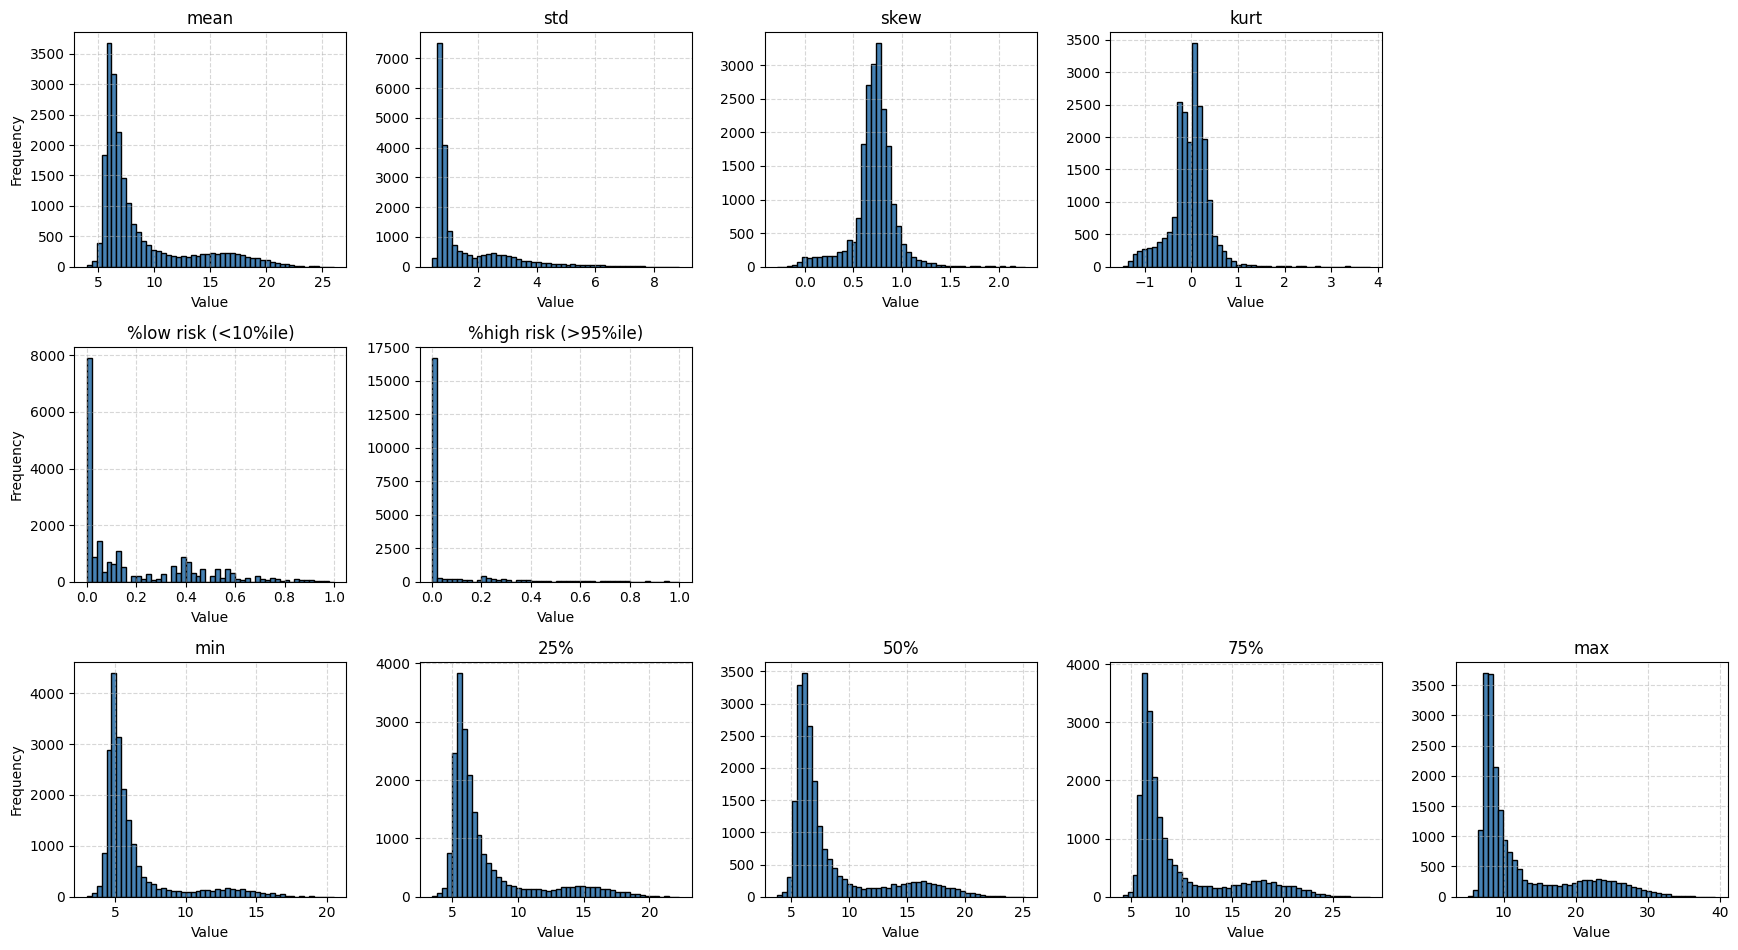

In [57]:

def mask_zeros(arr):
    flat = arr.flatten()
    flat[all_zero_mask] = np.nan
    return flat.reshape(raster_shape)

all_zero_mask = np.all(data_matrix == 0, axis=1)

mean_map_masked = mask_zeros(mean_map)
min_map_masked = mask_zeros(min_map)
p25_map_masked = mask_zeros(p25_map)
p50_map_masked = mask_zeros(p50_map)
p75_map_masked = mask_zeros(p75_map)
max_map_masked = mask_zeros(max_map)

masked_data_maps = [
    mean_map_masked, std_map, skew_map, kurt_map,
    perc_low_risk_map, perc_high_risk_map,
    min_map_masked, p25_map_masked, p50_map_masked, p75_map_masked, max_map_masked
]

fig = plt.figure(figsize=(3.5 * 5, 3.2 * 3))
gs = GridSpec(3, 5, figure=fig)

positions = [
    (0, 0), (0, 1), (0, 2), (0, 3),
    (1, 0), (1, 1),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)
]

for (row, col), data, title in zip(positions, masked_data_maps, titles):
    ax = fig.add_subplot(gs[row, col])
    values = data.flatten()
    values = values[~np.isnan(values)]

    ax.hist(values, bins=50, color='steelblue', edgecolor='black')

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Value')
    if col == 0:
        ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Spatial clustering

The following parameters are used for clustering:
> Flood Risk : min, percentiles, max, std, %low risk, %high risk

In [58]:
# Prepare data
all_zero_mask = (data_matrix == 0).all(axis=1)

perc_high_risk_map = perc_high_risk_map.ravel()
perc_high_risk_map[all_zero_mask] = 0
perc_low_risk_map = perc_low_risk_map.ravel()
perc_low_risk_map[all_zero_mask] = 0

X = np.vstack([std_map.ravel(),
               perc_high_risk_map,
               perc_low_risk_map,
               min_map.ravel(),
               p25_map.ravel(),
               p50_map.ravel(),
               p75_map.ravel(),
               max_map.ravel()]).T

mask = ~np.isnan(X).any(axis=1)
X_valid = X[mask]

In [60]:

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_valid)

pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X_scaled)

kmeans = MiniBatchKMeans(n_clusters=4, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# gmm = GaussianMixture(n_components=4, n_init=10, random_state=42)
# clusters = gmm.fit_predict(X_scaled)

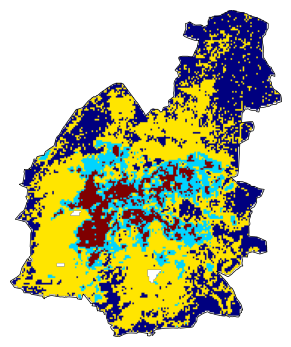

In [61]:

cluster_map = np.full(X.shape[0], fill_value=np.nan)
cluster_map[mask] = clusters
cluster_map = cluster_map.reshape(raster_shape)

plt.figure(figsize=(4, 4.25))
img = plt.imshow(cluster_map, cmap='jet', extent=extent, origin='upper')

roi_gdf.boundary.plot(ax=plt.gca(), color='black', lw=0.5)

# plt.title(f'Zero flood risks', fontsize=10)
plt.axis('off')
plt.show()

### Spatial autocorrelation

In [ ]:

from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import seaborn as sns

map_ = p50_map
height, width = map_.shape

left = meta['bounds'].left
right = meta['bounds'].right
top = meta['bounds'].top
bottom = meta['bounds'].bottom
pixel_w = meta['pixel_width']
pixel_h = meta['pixel_height']

lons = np.linspace(left + pixel_w/2, right - pixel_w/2, width)
lats = np.linspace(top - pixel_h/2, bottom + pixel_h/2, height)

lon_grid, lat_grid = np.meshgrid(lons, lats)

mask_valid = ~np.isnan(map_)
data_flat = pd.DataFrame({
    "Latitude": lat_grid[mask_valid],
    "Longitude": lon_grid[mask_valid],
    "mean_flood_risk": map_[mask_valid]
})

gdf = gpd.GeoDataFrame(
    data_flat,
    geometry=[Point(xy) for xy in zip(data_flat["Longitude"], data_flat["Latitude"])],
    crs="EPSG:4326"
)

w = weights.KNN.from_dataframe(gdf, k=5)
w.transform = "R"

gdf["lag"] = weights.spatial_lag.lag_spatial(w, gdf["mean_flood_risk"])
gdf["std"] = (gdf["mean_flood_risk"] - gdf["mean_flood_risk"].mean()) / gdf["mean_flood_risk"].std()
gdf["lag_std"] = weights.spatial_lag.lag_spatial(w, gdf["std"])

moran = esda.moran.Moran(gdf["mean_flood_risk"], w)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

im0 = axes[0].imshow(map_, cmap=custom_cmap, origin="upper", extent=(left, right, bottom, top), vmax=risk_thresh)
roi_gdf.boundary.plot(ax=axes[0], color="black", lw=0.5)
axes[0].set_title("Mean flood risk")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

lag_map = np.full_like(map_, np.nan)
lag_map[mask_valid] = gdf["lag"].values
im1 = axes[1].imshow(lag_map, cmap=custom_cmap, origin="upper", extent=(left, right, bottom, top), vmax=risk_thresh)
roi_gdf.boundary.plot(ax=axes[1], color="black", lw=0.5)
axes[1].set_title("Spatial Lag")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

sns.regplot(
    x="std",
    y="lag_std",
    data=gdf,
    ci=None,
    line_kws={"color": "r"},
    ax=axes[2]
)
axes[2].axvline(0, c="k", alpha=0.5)
axes[2].axhline(0, c="k", alpha=0.5)
axes[2].set_title(f"I={moran.I:.3f}, p={moran.p_sim}")
axes[2].set_xlabel("Standardized Flood Risk")
axes[2].set_ylabel("Standardized Spatial Lag")

plt.tight_layout()
plt.show()

##  Temporal analysis

### Temporal summary statistics

In [ ]:

valid_pixels_data = data_matrix[~(np.all(np.isnan(data_matrix), axis=1) | np.all(data_matrix == 0, axis=1))]

# Temporal stats
mean_temp = np.nanmean(valid_pixels_data, axis=0)
std_temp = np.nanstd(valid_pixels_data, axis=0)

perc_zeros_temp = (data_matrix[~np.isnan(data_matrix).all(axis=1) & ~(data_matrix == 0).all(axis=1)]==0).mean(axis=0)

for i in range(len(years)):
    subset = data_matrix[:, :i + 1]
    mask_valid = ~np.isnan(subset).any(axis=1)
    valid_subset = subset[mask_valid]

threshold = np.percentile(data_matrix[~np.isnan(data_matrix).all(axis=1) & ~(data_matrix == 0).all(axis=1)], 90, axis=1).mean()
perc_high_risk_temp = (data_matrix[~np.isnan(data_matrix).all(axis=1) & ~(data_matrix==0).all(axis=1)]>threshold).mean(axis=0)

threshold = np.percentile(data_matrix[~np.isnan(data_matrix).all(axis=1) & ~(data_matrix == 0).all(axis=1)], 10, axis=1).mean()
perc_low_risk_temp = (data_matrix[~np.isnan(data_matrix).all(axis=1) & ~(data_matrix==0).all(axis=1)]<threshold).mean(axis=0)

min_temp = np.nanmin(valid_pixels_data, axis=0)
p25_temp = np.nanpercentile(valid_pixels_data, 25, axis=0)
p50_temp = np.nanpercentile(valid_pixels_data, 50, axis=0)
p75_temp = np.nanpercentile(valid_pixels_data, 75, axis=0)
p90_temp = np.nanpercentile(valid_pixels_data, 90, axis=0)
p99_temp = np.nanpercentile(valid_pixels_data, 99, axis=0)
max_temp = np.nanmax(valid_pixels_data, axis=0)

fig = make_subplots(
    rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.015)

fig.add_trace(go.Scatter(x=years, y=mean_temp, mode='lines+markers', name='mean', showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=years, y=std_temp, mode='lines+markers', name='std', showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=years, y=perc_low_risk_temp, mode='lines+markers', name='% low risk', showlegend=False), row=3, col=1)

fig.add_trace(go.Scatter(x=years, y=perc_high_risk_temp, mode='lines+markers', name='% high risk', showlegend=False), row=4, col=1)

percentiles_data = {
    'min': min_temp,
    '25%': p25_temp,
    '50%': p50_temp,
    '75%': p75_temp,
    '90%': p90_temp,
    '99%': p99_temp,
    'max': max_temp
}
for label, data in reversed(percentiles_data.items()):
    fig.add_trace(go.Scatter(x=years, y=data, mode='lines+markers', name=label), row=5, col=1)

fig.update_yaxes(title_text="mean", row=1, col=1)
fig.update_yaxes(title_text="std", row=2, col=1)
fig.update_yaxes(title_text="% low risk", row=3, col=1)
fig.update_yaxes(title_text="% high risk", row=4, col=1)
fig.update_yaxes(title_text="percentiles", row=5, col=1)

fig.update_xaxes(range=[min(years), max(years)])

fig.update_layout(
    legend=dict(y=-0.005),
    height=150*5, width=950,
    margin=dict(l=75, r=20, t=0, b=40),
)

fig.show()
# png_bytes = fig.to_image(format="png")
# display(Image(png_bytes))

### Trend analysis

In [ ]:

trend_dict = {}
resid_dict = {}

from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.express as px

px_colors = px.colors.qualitative.Plotly

fig = make_subplots(
    rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.015
)

def add_with_lowess_and_residuals(x, y, row, col, name, color, frac=0.3, showlegend=False):
    fig.add_trace(
        go.Scatter(
            x=x, y=y, mode='lines+markers', name=name,
            line=dict(color=color, dash="dot"),
            marker=dict(color=color),
            legendgroup=name if showlegend else None,
            showlegend=False,
            visible=True
        ),
        row=row, col=col
    )
    
    trend = lowess(y, x, frac=frac, return_sorted=False)
    residuals = np.asarray(y) - trend

    trend_dict[name] = trend
    resid_dict[name] = residuals

    fig.add_trace(
        go.Scatter(
            x=x, y=trend, mode='lines', name=name,
            line=dict(color=color),
            legendgroup=name if showlegend else None,
            showlegend=showlegend,
            visible=True
        ),
        row=row, col=col
    )

    fig.add_trace(
        go.Scatter(
            x=x, y=residuals, mode='lines+markers', name=name,
            line=dict(color=color),
            marker=dict(color=color),
            legendgroup=name if showlegend else None,
            showlegend=showlegend,
            visible=False
        ),
        row=row, col=col
    )

add_with_lowess_and_residuals(years, mean_temp, row=1, col=1, name="mean", color=px_colors[0], showlegend=False)
add_with_lowess_and_residuals(years, std_temp, row=2, col=1, name="std", color=px_colors[1])
add_with_lowess_and_residuals(years, perc_low_risk_temp, row=3, col=1, name="%low_risk", color=px_colors[3])
add_with_lowess_and_residuals(years, perc_high_risk_temp, row=4, col=1, name="%high_risk", color=px_colors[4])

percentiles_data = {
    'min': min_temp,
    '25%': p25_temp,
    '50%': p50_temp,
    '75%': p75_temp,
    '90%': p90_temp,
    '99%': p99_temp,
    'max': max_temp
}
for i, (label, data) in enumerate(reversed(percentiles_data.items())):
    color = px_colors[i % len(px_colors)]
    add_with_lowess_and_residuals(years, data, row=5, col=1, name=label, color=color, showlegend=True)

fig.update_xaxes(range=[min(years), max(years)])

fig.update_yaxes(title_text="mean", row=1, col=1)
fig.update_yaxes(title_text="std", row=2, col=1)
fig.update_yaxes(title_text="% low risk", row=3, col=1)
fig.update_yaxes(title_text="% high risk", row=4, col=1)
fig.update_yaxes(title_text="percentiles", row=5, col=1)

total_traces = len(fig.data)
main_visibility = []
resid_visibility = []
for i in range(total_traces):
    if i % 3 == 2:
        main_visibility.append(False)
        resid_visibility.append(True)
        fig.data[i].visible = False
    else:
        main_visibility.append(True)
        resid_visibility.append(False)
        fig.data[i].visible = True

fig.update_layout(
    height=150*5, width=950,
    margin=dict(l=80, r=20, t=10, b=40),
    legend=dict(y=-0.005, tracegroupgap=0),
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=[
                dict(label="Trend",
                     method="update",
                     args=[{"visible": main_visibility}]),
                dict(label="Residuals",
                     method="update",
                     args=[{"visible": resid_visibility}]),
            ],
            x=1.065, y=0.885,
            xanchor="center", yanchor="bottom"
        )
    ]
)

fig.show()
# png_bytes = fig.to_image(format="png")
# display(Image(png_bytes))

### Residual analysis

#### Stationarity

In [ ]:

from statsmodels.tsa.stattools import adfuller

adf_results = []

for col in resid_dict.keys():
    result = adfuller(resid_dict[col])
    
    result_dict = {
        "Statistic": col,
        "ADF Statistic": result[0].round(2),
        "p-value": f"{result[1]:.2e}",
        "Critical 1%": result[4]['1%'].round(2),
        "Critical 5%": result[4]['5%'].round(2),
        "Critical 10%": result[4]['10%'].round(2),
        "Stationary (p<0.05)": result[1] < 0.05
    }
    
    adf_results.append(result_dict)

df_adf = pd.DataFrame(adf_results).set_index('Statistic')
df_adf

#### Temporal autocorrelation

In [ ]:

from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator

max_lag = 11
alpha = 0.05
resid = resid_dict['mean']

acf_vals = acf(resid, nlags=max_lag, fft=True)
pacf_vals = pacf(resid, nlags=max_lag)

conf = norm.ppf(1 - alpha / 2) / np.sqrt(len(resid))

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

lags = np.arange(len(acf_vals))
markerline, stemlines, baseline = axes[0].stem(
    lags, acf_vals,
    linefmt='#636EFA', markerfmt='#636EFA', basefmt='#636EFA'
)
markerline.set_clip_on(False)
stemlines.set_clip_on(False)
markerline.set_zorder(3)
stemlines.set_zorder(3)

axes[0].axhspan(-conf, conf, color='#636EFA', alpha=0.2, zorder=0)
axes[0].set_title("Autocorrelation func for mean residual")
axes[0].set_ylabel("ACF")
axes[0].set_xlim(0, max_lag)
axes[0].xaxis.set_major_locator(MultipleLocator(base=5))
# axes[0].set_ylim(-0.5, 1)
axes[0].set_xlabel("Lag (years)")
axes[0].grid(True, alpha=0.5)

lags = np.arange(len(pacf_vals))
markerline, stemlines, baseline = axes[1].stem(
    lags, pacf_vals,
    linefmt='#636EFA', markerfmt='#636EFA', basefmt='#636EFA'
)
markerline.set_clip_on(False)
stemlines.set_clip_on(False)
markerline.set_zorder(3)
stemlines.set_zorder(3)

axes[1].axhspan(-conf, conf, color='#636EFA', alpha=0.2, zorder=0)
axes[1].set_title("Partial Autocorrelation func for mean residual")
axes[1].set_ylabel("PACF")
axes[1].set_xlim(0, max_lag)
axes[1].xaxis.set_major_locator(MultipleLocator(base=5))
# axes[1].set_ylim(-0.5, 1)
axes[1].set_xlabel("Lag (years)")
axes[1].grid(True, alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

#### Change point detection

In [ ]:

import ruptures as rpt

resid = resid_dict['%high_risk']

algo = rpt.Binseg(model='rbf').fit(resid)
n_bkps = 4  # max number of change points to find
bkps = algo.predict(n_bkps=n_bkps)

rpt.display(resid, bkps, figsize=(10, 2))
plt.title("Change Point Detection - Residual")
plt.show()

print("Change points detected at indices:", bkps)

## Spatio-Temporal analysis

In [ ]:
# Temporal variation of Spatial distribution
from PIL import Image as PILImage
import io
import base64

image_frames = []
sliders_steps = []
center_lat = center_lon = None
initial_layers = []

for i, year in enumerate(years):
    array, meta = read_raster_as_array(year, city=city, nodata_value=-9999, meta_data=True, target_pixels=target_pixels)
    array_normalized = np.clip(array / risk_thresh, 0, 1)
    
    colored = custom_cmap(array_normalized)
    
    alpha_channel = np.where(np.isnan(array_normalized), 0, 255).astype(np.uint8)
    
    rgb_array = (colored[:, :, :3] * 255).astype(np.uint8)
    rgba_array = np.dstack((rgb_array, alpha_channel))
    
    image = PILImage.fromarray(rgba_array.astype(np.uint8))
    buffer = io.BytesIO()
    image.save(buffer, format='PNG')
    buffer.seek(0)
    encoded_image = "data:image/png;base64," + base64.b64encode(buffer.read()).decode()
    
    bounds = meta['bounds']
    
    image_coordinates = [
        [bounds[0], bounds[3]],
        [bounds[2], bounds[3]],
        [bounds[2], bounds[1]],
        [bounds[0], bounds[1]],
    ]
    
    if center_lat is None:
        center_lat = (bounds[1] + bounds[3]) / 2
        center_lon = (bounds[0] + bounds[2]) / 2
    
    layer = dict(
        sourcetype='image',
        source=encoded_image,
        coordinates=image_coordinates,
        below='traces',
        opacity=1
    )
    
    if i == 0:
        initial_layers = [layer]
    
    image_frames.append(go.Frame(
        name=str(year),
        layout=go.Layout(mapbox=dict(layers=[layer]))
    ))
    
    sliders_steps.append({
        "args": [[str(year)], {"frame": {"duration": 600, "redraw": True},
                               "mode": "immediate"}],
        "label": str(year),
        "method": "animate"
    })

fig = go.Figure(
    data=[go.Scattermapbox(
        lat=[center_lat],
        lon=[center_lon],
        mode='markers',
        marker=dict(size=1, color='rgba(0,0,0,0)'),
        hoverinfo='skip'
    )],
    layout=go.Layout(
        width=460,
        height=450,
        margin=dict(l=0, r=0, t=0, b=0),
        mapbox=dict(
            style='open-street-map',
            center=dict(lat=center_lat, lon=center_lon),
            zoom={
                'New-Delhi': 8.825,
                'Indore': 10
            }.get(city, 9),
            layers=initial_layers
        ),
        sliders=[{
            "active": 0,
            "steps": sliders_steps,
            "x": 0.05,
            "len": 0.6,
            "xanchor": "left",
            "y": 0.02,
            "yanchor": "bottom",
            "pad": {"b": 0, "t": 0},
            "currentvalue": {
                "visible": True,
                "prefix": "Year: ",
                "xanchor": "left",
                "font": {"size": 14}
            },
            "transition": {"duration": 400, "easing": "cubic-in-out"},
            "font": {"size": 10}
        }],
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "direction": "right",
            "y": 0.255,
            "x": 0.225,
            "xanchor": "right",
            "yanchor": "top",
            "pad": {"t": 0, "r": 10},
            "buttons": [
                {
                    "label": "▶︎",
                    "method": "animate",
                    "args": [None, {
                        "frame": {"duration": 400, "redraw": True},
                        "fromcurrent": True,
                        "transition": {"duration": 400, "easing": "cubic-in-out"}
                    }]
                },
                {
                    "label": "||",
                    "method": "animate",
                    "args": [[None], {
                        "mode": "immediate",
                        "frame": {"duration": 0, "redraw": False},
                        "transition": {"duration": 0}
                    }]
                }
            ]
        }]
    ),
    frames=image_frames
)

fig.show()
# png_bytes = fig.to_image(format="png")
# display(Image(png_bytes))

In [ ]:
# Spatial variation of Temporal trend
n_pixels, n_years = data_matrix.shape

X_centered = np.array(years) - np.array(years).mean()
denom = np.sum(X_centered ** 2)

mask_valid = ~np.isnan(data_matrix).any(axis=1)

slopes_flat = np.full(n_pixels, np.nan)

Y_valid = data_matrix[mask_valid]
slopes_flat[mask_valid] = np.sum(
    X_centered * (Y_valid - Y_valid.mean(axis=1, keepdims=True)),
    axis=1
) / denom

slopes_raster = slopes_flat.reshape(raster_shape)

plt.figure(figsize=(4.5, 4.5))
img = plt.imshow(
    slopes_raster,
    cmap=custom_cmap,
    extent=extent,
    origin='upper'
)
roi_gdf.boundary.plot(ax=plt.gca(), color='black', lw=0.5)

plt.colorbar(img, label='Trend slope (flood risk units/year)', fraction=0.04, pad=0.12)
plt.axis('off')
plt.show()


In [ ]:
# Spatial variation of residuals 
X_centered = np.array(years) - np.array(years).mean()
denom = np.sum(X_centered ** 2)

mask_valid = ~np.isnan(data_matrix).any(axis=1)
residuals = np.full_like(data_matrix, np.nan)

Y_valid = data_matrix[mask_valid]

slopes = np.sum(
    X_centered * (Y_valid - Y_valid.mean(axis=1, keepdims=True)),
    axis=1
) / denom
intercepts = Y_valid.mean(axis=1) - slopes * np.mean(years)

preds = intercepts[:, None] + slopes[:, None] * np.array(years)

residuals[mask_valid] = Y_valid - preds

image_frames = []
sliders_steps = []
center_lat = center_lon = None
initial_layers = []

vmin = np.nanmin(residuals)
vmax = np.nanmax(residuals)

cmap = plt.get_cmap('RdBu_r')

for i, year in enumerate(years):
    array = residuals[:, i].reshape(raster_shape)
    array_normalized = np.clip((array - vmin) / (vmax - vmin), 0, 1)
    colored = cmap(array_normalized)
    alpha_channel = np.where(np.isnan(array), 0, 255).astype(np.uint8)
    rgb_array = (colored[:, :, :3] * 255).astype(np.uint8)
    rgba_array = np.dstack((rgb_array, alpha_channel))
    image = PILImage.fromarray(rgba_array)
    buffer = io.BytesIO()
    image.save(buffer, format='PNG')
    buffer.seek(0)
    encoded_image = "data:image/png;base64," + base64.b64encode(buffer.read()).decode()
    bounds = meta['bounds']
    image_coordinates = [
        [bounds[0], bounds[3]],
        [bounds[2], bounds[3]],
        [bounds[2], bounds[1]],
        [bounds[0], bounds[1]],
    ]
    if center_lat is None:
        center_lat = (bounds[1] + bounds[3]) / 2
        center_lon = (bounds[0] + bounds[2]) / 2
    layer = dict(
        sourcetype='image',
        source=encoded_image,
        coordinates=image_coordinates,
        below='traces',
        opacity=1
    )
    if i == 0:
        initial_layers = [layer]
    image_frames.append(go.Frame(
        name=str(year),
        layout=go.Layout(mapbox=dict(layers=[layer]))
    ))
    sliders_steps.append({
        "args": [[str(year)], {"frame": {"duration": 600, "redraw": True},
                               "mode": "immediate"}],
        "label": str(year),
        "method": "animate"
    })

import json
boundary_json = json.loads(roi_gdf.to_json())

boundary_coords = []
for feature in boundary_json['features']:
    geom = feature['geometry']
    if geom['type'] == 'Polygon':
        for ring in geom['coordinates']:
            lats, lons = zip(*[(coord[1], coord[0]) for coord in ring])
            boundary_coords.append((lats, lons))
    elif geom['type'] == 'MultiPolygon':
        for polygon in geom['coordinates']:
            for ring in polygon:
                lats, lons = zip(*[(coord[1], coord[0]) for coord in ring])
                boundary_coords.append((lats, lons))

boundary_traces = []
for lats, lons in boundary_coords:
    boundary_traces.append(
        go.Scattermapbox(
            lat=lats,
            lon=lons,
            mode='lines',
            line=dict(color='black', width=0.5),
            showlegend=False,
            hoverinfo='skip'
        )
    )

fig = go.Figure(
    data=[
        go.Scattermapbox(
            lat=[center_lat], lon=[center_lon],
            mode='markers',
            marker=dict(size=1, color='rgba(0,0,0,0)'),
            hoverinfo='skip'
        )
    ] + boundary_traces,
    layout=go.Layout(
        width=460, height=450, margin=dict(l=0, r=0, t=0, b=0),
        showlegend=False,
        mapbox=dict(
            style='open-street-map',
            center=dict(lat=center_lat, lon=center_lon),
            zoom={'New-Delhi': 8.825, 'Indore': 10}.get(city, 9),
            layers=initial_layers
        ),
        sliders=[{
            "active": 0,
            "steps": sliders_steps,
            "x": 0.05, "len": 0.6, "xanchor": "left",
            "y": 0.02, "yanchor": "bottom",
            "pad": {"b": 0, "t": 0},
            "currentvalue": {"visible": True, "prefix": "Year: ", "xanchor": "left", "font": {"size": 14}},
            "transition": {"duration": 400, "easing": "cubic-in-out"},
            "font": {"size": 10}
        }],
        updatemenus=[{
            "type": "buttons", "showactive": False, "direction": "right",
            "y": 0.255, "x": 0.225, "xanchor": "right", "yanchor": "top",
            "pad": {"t": 0, "r": 10},
            "buttons": [
                {
                    "label": "▶︎", "method": "animate",
                    "args": [None, {"frame": {"duration": 400, "redraw": True},
                                    "fromcurrent": True,
                                    "transition": {"duration": 400, "easing": "cubic-in-out"}}]
                },
                {
                    "label": "||", "method": "animate",
                    "args": [[None], {"mode": "immediate",
                                      "frame": {"duration": 0, "redraw": False},
                                      "transition": {"duration": 0}}]
                }
            ]
        }]
    ),
    frames=image_frames
)

fig.show()
# png_bytes = fig.to_image(format="png")
# display(Image(png_bytes))

In [ ]:
# Spatial variation of temporal standard deviation of residuals
n_pixels, n_years = residuals.shape

std_flat = np.full(n_pixels, np.nan)

mask_valid = ~np.isnan(residuals).any(axis=1)

R_valid = residuals[mask_valid]
std_flat[mask_valid] = np.std(R_valid, axis=1)

std_raster = std_flat.reshape(raster_shape)

# Spatial variation of temporal autocorrelation (lag-1)
acf1_flat = np.full(n_pixels, np.nan)

mask_valid = ~np.isnan(residuals).any(axis=1) & ~(data_matrix == 0).all(axis=1)
R_valid = residuals[mask_valid]

R_centered = R_valid - R_valid.mean(axis=1, keepdims=True)

num = np.sum(R_centered[:, :-1] * R_centered[:, 1:], axis=1)

den = np.sum(R_centered ** 2, axis=1)

acf1_flat[mask_valid] = num / den

acf1_raster = acf1_flat.reshape(raster_shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axes[0])
img1 = plt.imshow(
    std_raster,
    cmap=custom_cmap,
    extent=extent,
    origin='upper'
)
roi_gdf.boundary.plot(ax=plt.gca(), color='black', lw=0.5)
plt.colorbar(img1, label='Temporal std', fraction=0.04, pad=0.12)
plt.axis('off')

plt.sca(axes[1])
img2 = plt.imshow(
    acf1_raster,
    cmap='coolwarm',
    extent=extent,
    origin='upper',
)
roi_gdf.boundary.plot(ax=plt.gca(), color='black', lw=0.5)
plt.colorbar(img2, label='Lag-1 autocorrelation', fraction=0.04, pad=0.12)
plt.axis('off')

plt.show()
